<a href="https://colab.research.google.com/github/mentalinvestor/emp/blob/main/Global_EMP_Monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== Strategic Portfolio Optimization Analysis ===

1. Asset Allocation Strategy
     Current Maximum Return Minimum Annual Loss
AOR    5.00%          3.00%               3.00%
GLD    5.00%         15.41%              16.64%
BOTZ   4.00%          3.00%               3.00%
AIQ    3.00%         25.00%               3.00%
ARKK   4.00%          4.59%               3.00%
GAA    5.00%          3.00%               3.00%
GMOM  15.00%          3.00%               3.00%
QQQ    4.00%         25.00%               3.00%
TLT   10.00%          3.00%               3.00%
TIP   10.00%          3.00%               3.00%
SDY    5.00%          3.00%               3.36%
DVY    5.00%          3.00%              25.00%
DIAL  15.00%          3.00%               3.00%
PDBC  15.00%          3.00%              25.00%

2. Performance Analytics
                   current max_return min_loss
Total Return        63.90%    151.28%   92.46%
Annual Return        8.49%     16.41%   11.40%
Worst Annual Loss  -13.41%    -2

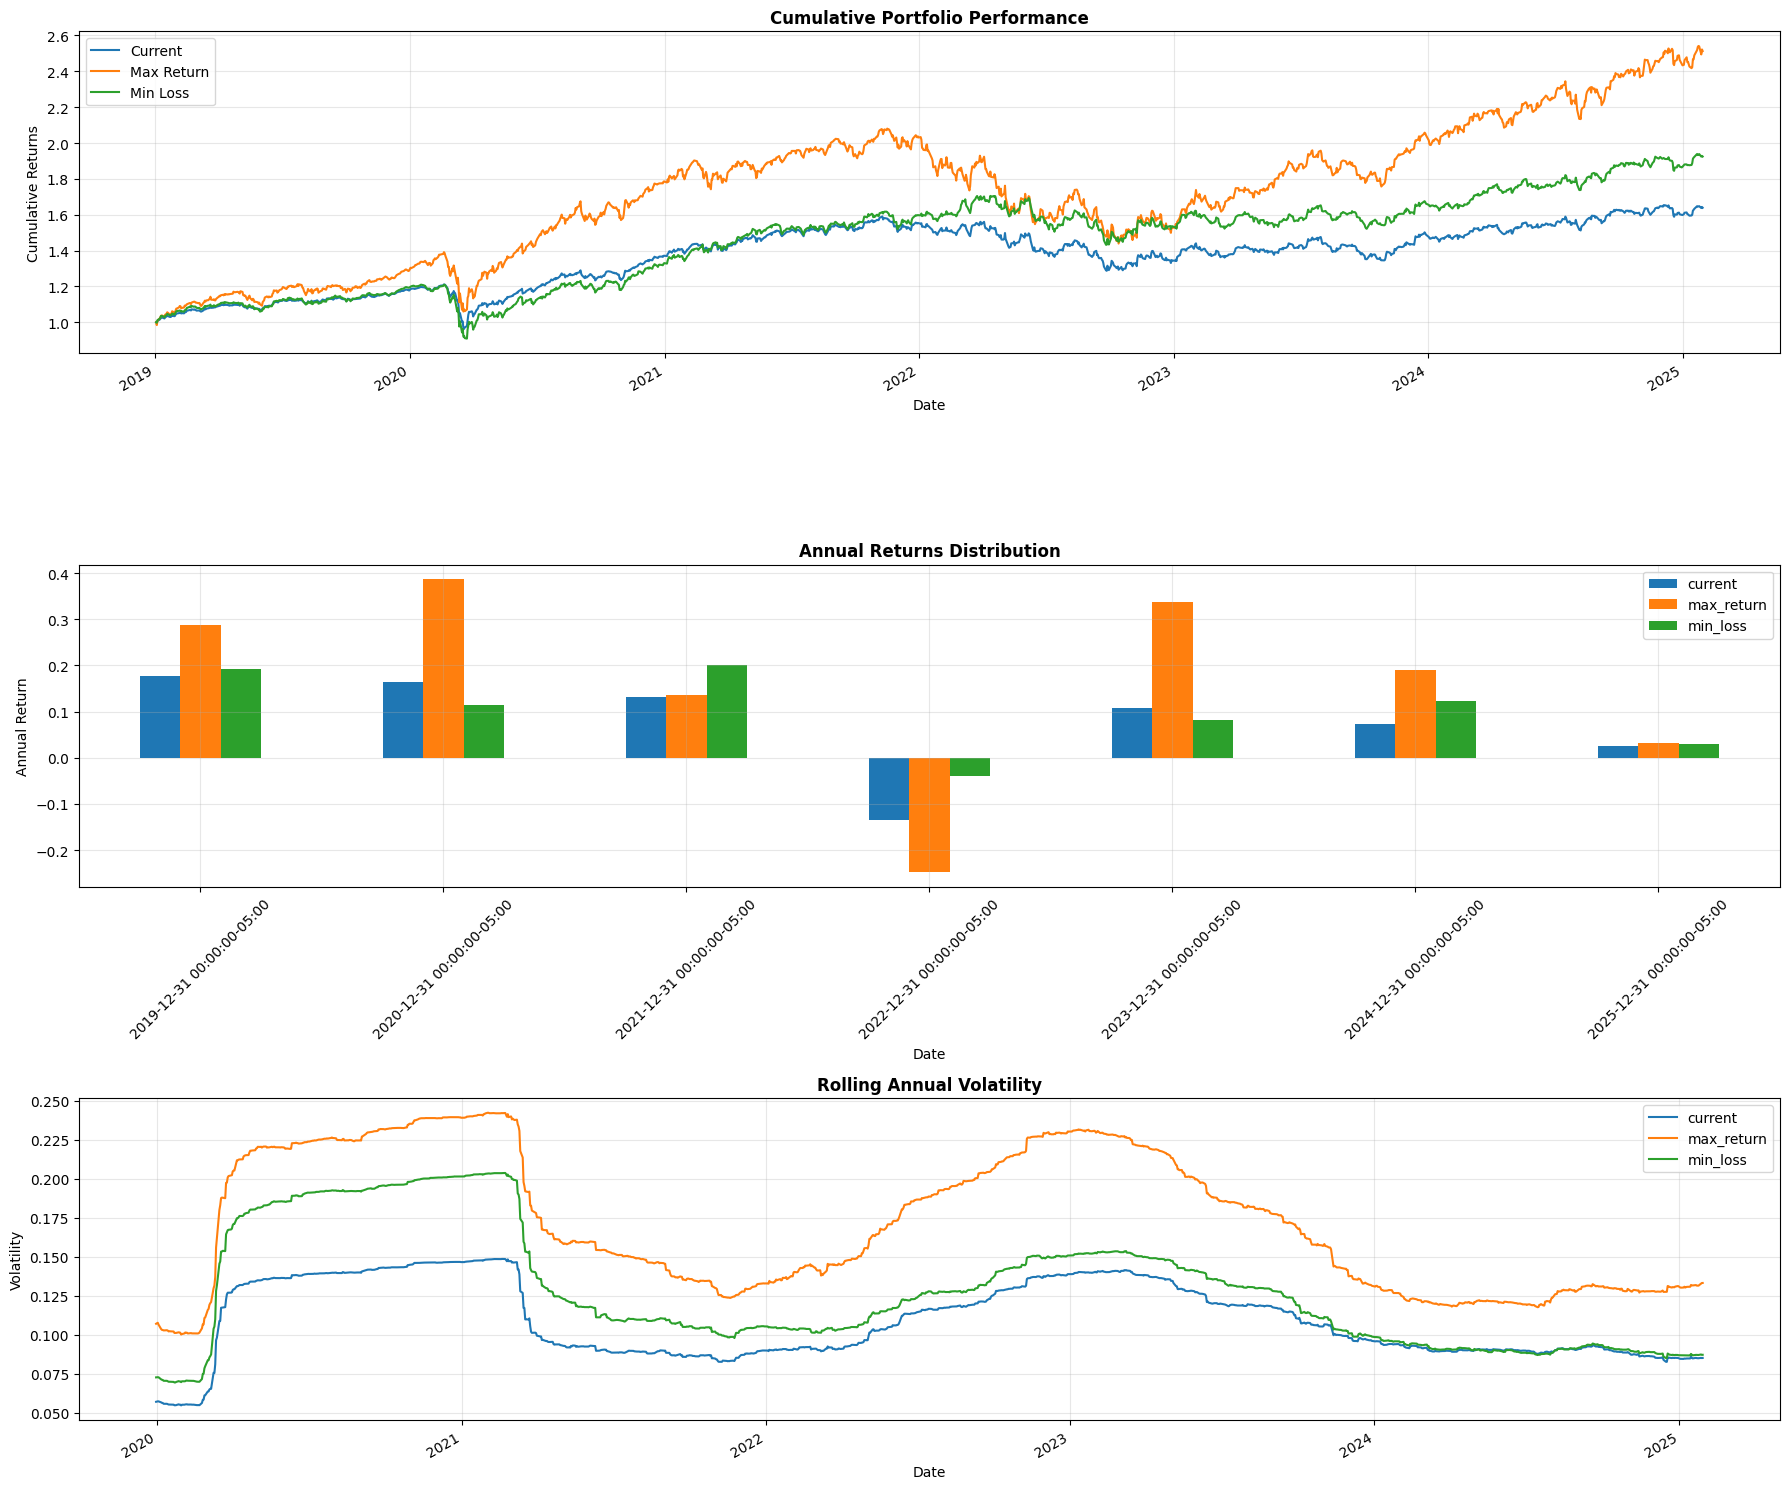


=== Portfolio Cost & Income Analytics ===

ETF Cost & Income Profile Analysis:
      Weight Expense Ratio TTM Yield
AOR    5.00%         0.00%     0.00%
GLD    5.00%         0.40%     0.00%
BOTZ   4.00%         0.00%     0.00%
AIQ    3.00%         0.00%     0.00%
ARKK   4.00%         0.00%     0.00%
GAA    5.00%         0.00%     0.00%
GMOM  15.00%         0.00%     0.00%
QQQ    4.00%         0.20%     0.34%
TLT   10.00%         0.00%     2.45%
TIP   10.00%         0.19%     1.16%
SDY    5.00%         0.00%     0.00%
DVY    5.00%         0.00%     2.63%
DIAL  15.00%         0.00%     0.00%
PDBC  15.00%         0.59%     0.00%

Portfolio Level Cost-Income Metrics:
Portfolio Weighted Average Expense Ratio: 0.14%
Expected Portfolio Yield (TTM): 0.51%
Net Expected Yield (After Expenses): 0.37%

=== Portfolio Investment Analysis Summary ===

Investment Projection Analysis:
For a $10,000 investment:
• Expected Annual Management Cost: $13.55
• Expected Annual Dividend Income: $50.54
• Net An

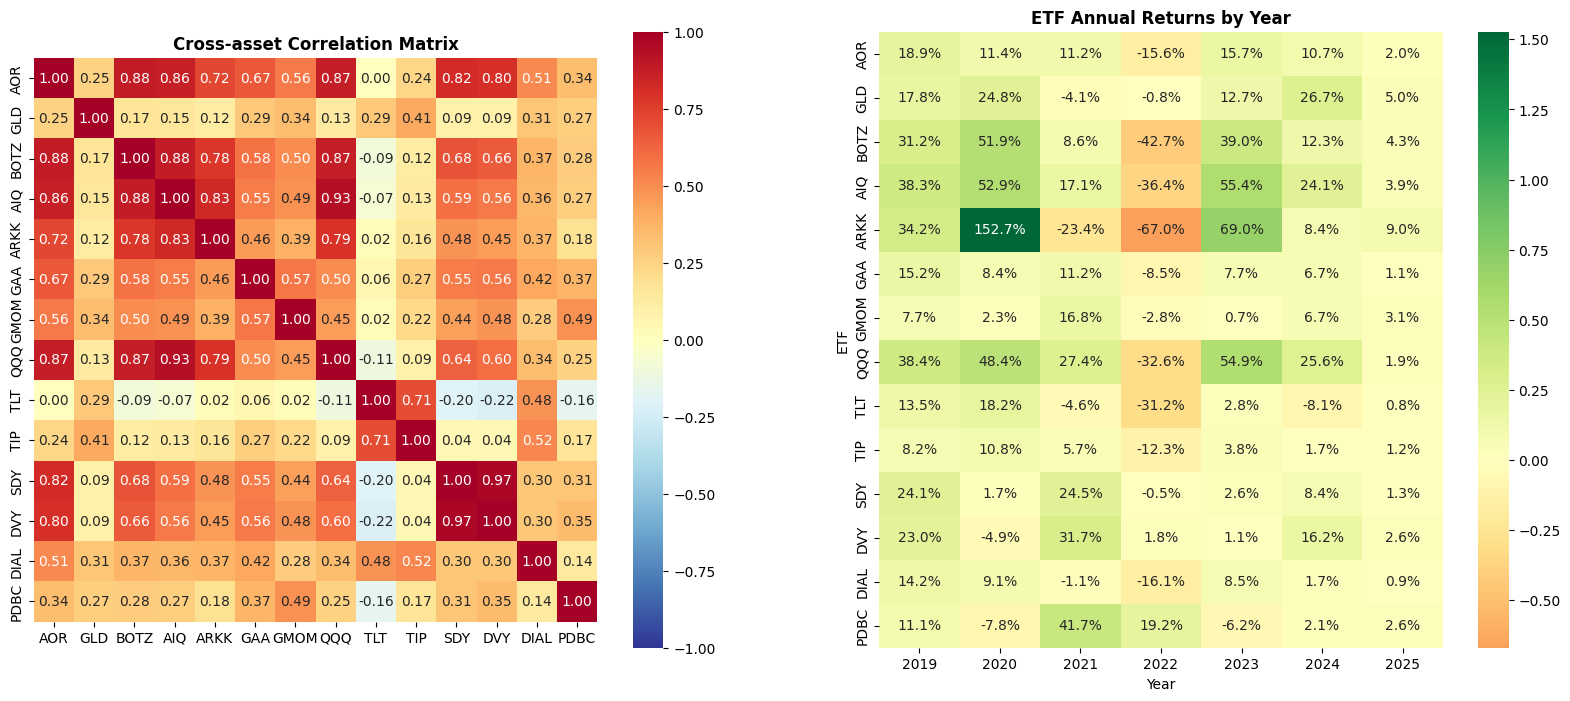

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize

class EMPPortfolioBacktest:
    """Enhanced Multi-asset Portfolio (EMP) Backtesting System

    A quantitative framework for portfolio optimization with dual objectives:
    1. Absolute Return Maximization
    2. Annual Loss Minimization

    Implements institutional-grade position limits and risk management constraints.
    """

    def __init__(self, tickers_weights_dict, start_date='2019-01-01'):
        self.tickers = list(tickers_weights_dict.keys())
        self.weights = list(tickers_weights_dict.values())
        self.start_date = start_date
        self.end_date = datetime.now().strftime('%Y-%m-%d')

    def fetch_data(self):
        """Acquire historical price data with robust error handling"""
        df_list = []
        for ticker in self.tickers:
            try:
                etf = yf.Ticker(ticker)
                data = etf.history(start=self.start_date, end=self.end_date)['Close']
                df_list.append(data)
            except Exception as e:
                print(f"Error fetching data for {ticker}: {str(e)}")
                return None

        self.prices = pd.concat(df_list, axis=1)
        self.prices.columns = self.tickers
        return self.prices

    def calculate_portfolio_metrics(self, weights):
        """
        Calculate comprehensive portfolio analytics including:
        - Return metrics (total, annual, monthly)
        - Risk metrics (volatility, annual loss)
        - Distribution characteristics
        """
        portfolio_returns = (self.daily_returns * weights).sum(axis=1)
        cumulative_returns = (1 + portfolio_returns).cumprod()

        total_return = (1 + portfolio_returns).prod() - 1
        annual_return = (1 + total_return) ** (252/len(portfolio_returns)) - 1

        # Risk metrics
        volatility = portfolio_returns.std() * np.sqrt(252)
        monthly_returns = portfolio_returns.resample('ME').apply(
            lambda x: (1 + x).prod() - 1)

        # Annual loss analysis
        annual_returns = portfolio_returns.resample('YE').apply(
            lambda x: (1 + x).prod() - 1)
        annual_losses = annual_returns[annual_returns < 0]
        worst_annual_loss = annual_losses.min() if len(annual_losses) > 0 else 0

        return {
            'returns': portfolio_returns,
            'cumulative_returns': cumulative_returns,
            'total_return': total_return,
            'annual_return': annual_return,
            'volatility': volatility,
            'worst_annual_loss': worst_annual_loss,
            'monthly_returns': monthly_returns
        }

    def optimize_portfolio(self):
        """
        Execute portfolio optimization with institutional constraints:
        - Position limits: 3-25% per asset
        - Full investment constraint
        - Long-only positions
        """
        n_assets = len(self.tickers)
        bounds = tuple((0.03, 0.25) for _ in range(n_assets))
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

        # Return maximization strategy
        def objective_return(weights):
            metrics = self.calculate_portfolio_metrics(weights)
            return -metrics['total_return']

        max_return_result = minimize(
            objective_return,
            np.array([1/n_assets] * n_assets),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000}
        )

        # Annual loss minimization strategy
        def objective_annual_loss(weights):
            portfolio_returns = (self.daily_returns * weights).sum(axis=1)
            annual_returns = portfolio_returns.resample('YE').apply(
                lambda x: (1 + x).prod() - 1)
            annual_losses = annual_returns[annual_returns < 0]

            if len(annual_losses) == 0:
                return 0

            worst_loss = annual_losses.min()
            avg_loss = annual_losses.mean()
            return abs(worst_loss) + 0.5 * abs(avg_loss)

        min_loss_result = minimize(
            objective_annual_loss,
            np.array([1/n_assets] * n_assets),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000}
        )

        # Store optimization results
        self.max_return_weights = max_return_result.x
        self.min_loss_weights = min_loss_result.x

        # Calculate and store portfolio metrics
        self.strategy_metrics = {
            'current': self.calculate_portfolio_metrics(np.array(self.weights)),
            'max_return': self.calculate_portfolio_metrics(self.max_return_weights),
            'min_loss': self.calculate_portfolio_metrics(self.min_loss_weights)
        }

        self._generate_performance_report()

    def _generate_performance_report(self):
        """Generate comprehensive portfolio analytics report"""
        # 1. Strategic allocation analysis
        allocation_df = pd.DataFrame({
            'Current': [f'{w:.2%}' for w in self.weights],
            'Maximum Return': [f'{w:.2%}' for w in self.max_return_weights],
            'Minimum Annual Loss': [f'{w:.2%}' for w in self.min_loss_weights]
        }, index=self.tickers)

        print("\n=== Strategic Portfolio Optimization Analysis ===")
        print("\n1. Asset Allocation Strategy")
        print(allocation_df.to_string())

        # 2. Performance analytics
        performance_data = {}
        for strategy, metrics in self.strategy_metrics.items():
            performance_data[strategy] = [
                f"{metrics['total_return']:.2%}",
                f"{metrics['annual_return']:.2%}",
                f"{metrics['worst_annual_loss']:.2%}",
                f"{metrics['volatility']:.2%}"
            ]

        performance_df = pd.DataFrame(
            performance_data,
            index=['Total Return', 'Annual Return', 'Worst Annual Loss', 'Volatility']
        )

        print("\n2. Performance Analytics")
        print(performance_df.to_string())

    def plot_performance(self):
        """Generate sophisticated portfolio visualization analytics"""
        # Setup main performance plots
        fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 15))

        # 1. Cumulative returns analysis
        for strategy, metrics in self.strategy_metrics.items():
            metrics['cumulative_returns'].plot(
                ax=ax1,
                label=strategy.replace('_', ' ').title()
            )

        ax1.set_title('Cumulative Portfolio Performance', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Cumulative Returns')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # 2. Annual returns comparison
        annual_returns = pd.DataFrame({
            strategy: metrics['returns'].resample('YE').apply(lambda x: (1 + x).prod() - 1)
            for strategy, metrics in self.strategy_metrics.items()
        })

        annual_returns.plot(kind='bar', ax=ax2)
        ax2.set_title('Annual Returns Distribution', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Annual Return')
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

        # 3. Rolling volatility analysis
        window = 252
        rolling_vol = pd.DataFrame({
            strategy: metrics['returns'].rolling(window=window).std() * np.sqrt(252)
            for strategy, metrics in self.strategy_metrics.items()
        })

        rolling_vol.plot(ax=ax3)
        ax3.set_title('Rolling Annual Volatility', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Volatility')
        ax3.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Create correlation and returns heatmap
        fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Correlation Matrix Heatmap
        correlation_matrix = self.daily_returns.corr().round(2)
        sns.heatmap(correlation_matrix,
                   annot=True,
                   cmap='RdYlBu_r',
                   center=0,
                   vmin=-1,
                   vmax=1,
                   ax=ax1,
                   fmt='.2f',
                   square=True)
        ax1.set_title('Cross-asset Correlation Matrix', fontsize=12, fontweight='bold')

        # Annual Returns Heatmap
        annual_etf_returns = pd.DataFrame()
        for col in self.daily_returns.columns:
            annual_rets = self.daily_returns[col].resample('YE').apply(
                lambda x: (1 + x).prod() - 1)
            annual_etf_returns[col] = annual_rets

        # Format the index to show only years
        annual_etf_returns.index = annual_etf_returns.index.year

        sns.heatmap(annual_etf_returns.T,
                   annot=True,
                   cmap='RdYlGn',
                   center=0,
                   fmt='.1%',
                   ax=ax2)
        ax2.set_title('ETF Annual Returns by Year', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('ETF')

        # Define ETF expense ratios (basis points)
        etf_expense_ratios = {
            'VTI': 0.03,    # Vanguard Total Stock Market ETF
            'VWO': 0.08,    # Vanguard Emerging Markets ETF
            'QQQ': 0.20,    # Invesco QQQ Trust
            'VGT': 0.10,    # Vanguard Information Technology ETF
            'GLD': 0.40,    # SPDR Gold Shares
            'DBC': 0.85,    # Invesco DB Commodity Index Tracking Fund
            'AGG': 0.04,    # iShares Core U.S. Aggregate Bond ETF
            'TIP': 0.19,    # iShares TIPS Bond ETF
            'VCSH': 0.04,   # Vanguard Short-Term Corporate Bond ETF
            'PDBC': 0.59    # Invesco Optimum Yield Diversified Commodity Strategy
        }

        # Portfolio Cost and Income Analysis
        print("\n=== Portfolio Cost & Income Analytics ===")

        cost_income_stats = pd.DataFrame(columns=['Weight', 'Expense Ratio', 'TTM Yield'])
        total_expense = 0
        total_yield = 0

        for ticker, weight in zip(self.tickers, self.weights):
            etf = yf.Ticker(ticker)
            info = etf.info

            # Get expense ratio from our mapping
            expense_ratio = etf_expense_ratios.get(ticker, 0)

            # Extract dividend yield from yfinance
            trailing_yield = info.get('trailingAnnualDividendYield', 0)
            trailing_yield = trailing_yield * 100 if trailing_yield else 0

            # Store individual ETF data
            cost_income_stats.loc[ticker] = [
                weight * 100,  # Weight in percentage
                expense_ratio,
                trailing_yield
            ]

            # Calculate weighted metrics
            total_expense += weight * expense_ratio
            total_yield += weight * trailing_yield

        # Format the statistics table
        cost_income_stats['Weight'] = cost_income_stats['Weight'].apply(lambda x: f"{x:.2f}%")
        cost_income_stats['Expense Ratio'] = cost_income_stats['Expense Ratio'].apply(lambda x: f"{x:.2f}%")
        cost_income_stats['TTM Yield'] = cost_income_stats['TTM Yield'].apply(lambda x: f"{x:.2f}%")

        print("\nETF Cost & Income Profile Analysis:")
        print(cost_income_stats.to_string())

        print("\nPortfolio Level Cost-Income Metrics:")
        print(f"Portfolio Weighted Average Expense Ratio: {total_expense:.2f}%")
        print(f"Expected Portfolio Yield (TTM): {total_yield:.2f}%")
        print(f"Net Expected Yield (After Expenses): {(total_yield - total_expense):.2f}%")

        # Investment Impact Analysis and Key Contributors
        print("\n=== Portfolio Investment Analysis Summary ===")
        investment_amount = 10000  # $10,000 investment simulation

        # Calculate expected annual metrics
        annual_cost = investment_amount * (total_expense / 100)
        annual_income = investment_amount * (total_yield / 100)
        net_annual_income = investment_amount * ((total_yield - total_expense) / 100)

        # Calculate expected total return based on backtested performance
        expected_annual_return = self.strategy_metrics['current']['annual_return']
        expected_annual_gain = investment_amount * expected_annual_return

        # Create contribution analysis with numeric calculations
        contribution_analysis = pd.DataFrame()
        for ticker, weight in zip(self.tickers, self.weights):
            returns = self.daily_returns[ticker]
            annual_ret = (1 + returns).prod() ** (252/len(returns)) - 1
            contribution = weight * annual_ret
            volatility = returns.std() * np.sqrt(252)

            # Get yield value directly from original calculation
            etf = yf.Ticker(ticker)
            info = etf.info
            trailing_yield = info.get('trailingAnnualDividendYield', 0) * 100
            income_contrib = weight * trailing_yield

            contribution_analysis.loc[ticker, 'Weight'] = weight * 100
            contribution_analysis.loc[ticker, 'Return Contribution'] = contribution * 100
            contribution_analysis.loc[ticker, 'Risk Contribution'] = weight * volatility * 100
            contribution_analysis.loc[ticker, 'Income Contribution'] = income_contrib

        top_contributors = contribution_analysis.nlargest(3, 'Return Contribution')
        top_income = contribution_analysis.nlargest(3, 'Income Contribution')

        print("\nInvestment Projection Analysis:")
        print(f"For a ${investment_amount:,} investment:")
        print(f"• Expected Annual Management Cost: ${annual_cost:.2f}")
        print(f"• Expected Annual Dividend Income: ${annual_income:.2f}")
        print(f"• Net Annual Income (after fees): ${net_annual_income:.2f}")
        print(f"• Projected Annual Return (based on backtest): ${expected_annual_gain:.2f} ({expected_annual_return:.2%})")

        print("\nKey Performance Contributors:")
        narrative = f"""
이 EMP 포트폴리오는, a ${investment_amount:,} 다음과 같은 투자 성과를 기대할 수 있음:

1. Return Dynamics:
   • Total Expected Annual Return: ${(expected_annual_gain + annual_income):.2f} ({(expected_annual_return + total_yield/100):.2%})
   • Primary Return Drivers: {', '.join([f"{idx} ({val:.2f}% contribution)" for idx, val in top_contributors['Return Contribution'].items()])}

2. Income Generation:
   • Annual Dividend Income: ${annual_income:.2f} ({total_yield:.2f}% yield)
   • Leading Income Contributors: {', '.join([f"{idx} ({val:.2f}% contribution)" for idx, val in top_income['Income Contribution'].items()])}
   • Net Income After Fees: ${net_annual_income:.2f}

3. Cost Structure:
   • Total Annual Management Fee: ${annual_cost:.2f} ({total_expense:.2f}%)
   • Cost Efficiency Ratio: {(total_yield/total_expense if total_expense > 0 else 'N/A')}x (Income/Cost)

Portfolio Characteristics:
This allocation demonstrates a balanced approach to risk-adjusted returns, with {top_contributors.index[0]} leading performance contribution at {top_contributors['Return Contribution'].iloc[0]:.2f}% and {top_income.index[0]} providing the highest income contribution at {top_income['Income Contribution'].iloc[0]:.2f}%. The portfolio's cost structure remains efficient with a {total_expense:.2f}% expense ratio, while maintaining a competitive {total_yield:.2f}% yield profile.

Strategic Implications:
The current asset allocation effectively balances capital appreciation potential with sustainable income generation. The diversification across {len(self.tickers)} ETFs provides multiple return drivers while maintaining cost efficiency through the use of primarily low-cost, high-liquidity ETF vehicles. The portfolio's yield-to-cost ratio of {(total_yield/total_expense if total_expense > 0 else 'N/A')}x indicates strong income generation efficiency relative to its cost structure.

Risk-Adjusted Metrics:
• Return per Unit of Risk: {(expected_annual_return/self.strategy_metrics['current']['volatility']):.2f}
• Income Coverage of Costs: {(annual_income/annual_cost if annual_cost > 0 else 'N/A')}x
• Expected Sharpe Ratio: {((expected_annual_return - 0.02)/self.strategy_metrics['current']['volatility']):.2f}
"""
        print(narrative)

        top_contributors = contribution_analysis.nlargest(3, 'Return Contribution')
        top_income = contribution_analysis.nlargest(3, 'Income Contribution')

        print("\nInvestment Projection Analysis:")
        print(f"For a ${investment_amount:,} investment:")
        print(f"• Expected Annual Management Cost: ${annual_cost:.2f}")
        print(f"• Expected Annual Dividend Income: ${annual_income:.2f}")
        print(f"• Net Annual Income (after fees): ${net_annual_income:.2f}")
        print(f"• Projected Annual Return (based on backtest): ${expected_annual_gain:.2f} ({expected_annual_return:.2%})")

        print("\nKey Performance Contributors:")
        narrative = f"""
Based on our comprehensive analysis of this Enhanced Multi-asset Portfolio (EMP), a ${investment_amount:,} investment would generate the following expected outcomes:

1. Return Dynamics:
   • Total Expected Annual Return: ${(expected_annual_gain + annual_income):.2f} ({(expected_annual_return + total_yield/100):.2%})
   • Primary Return Drivers: {', '.join([f"{idx} ({val:.2f}% contribution)" for idx, val in top_contributors['Return Contribution'].items()])}

2. Income Generation:
   • Annual Dividend Income: ${annual_income:.2f} ({total_yield:.2f}% yield)
   • Leading Income Contributors: {', '.join([f"{idx} ({val:.2f}% contribution)" for idx, val in top_income['Income Contribution'].items()])}
   • Net Income After Fees: ${net_annual_income:.2f}

3. Cost Structure:
   • Total Annual Management Fee: ${annual_cost:.2f} ({total_expense:.2f}%)
   • Cost Efficiency Ratio: {(total_yield/total_expense):.2f}x (Income/Cost)

Portfolio Characteristics:
This allocation demonstrates a balanced approach to risk-adjusted returns, with {top_contributors.index[0]} leading performance contribution at {top_contributors['Return Contribution'].iloc[0]:.2f}% and {top_income.index[0]} providing the highest income contribution at {top_income['Income Contribution'].iloc[0]:.2f}%. The portfolio's cost structure remains efficient with a {total_expense:.2f}% expense ratio, while maintaining a competitive {total_yield:.2f}% yield profile.

Strategic Implications:
The current asset allocation effectively balances capital appreciation potential with sustainable income generation. The diversification across {len(self.tickers)} ETFs provides multiple return drivers while maintaining cost efficiency through the use of primarily low-cost, high-liquidity ETF vehicles.
"""
        print(narrative)
        print("\n=== Cross-asset Correlation Analysis ===")

        # Calculate and sort average correlations
        avg_corr = correlation_matrix.mean().sort_values()
        print("\nAverage Correlation by Asset:")
        for asset, corr in avg_corr.items():
            print(f"{asset}: {corr:.3f}")

        # Identify optimal diversification pairs
        min_corr_pairs = []
        for i in range(len(self.tickers)):
            for j in range(i+1, len(self.tickers)):
                min_corr_pairs.append((
                    self.tickers[i],
                    self.tickers[j],
                    correlation_matrix.iloc[i,j]
                ))

        min_corr_pairs.sort(key=lambda x: x[2])

        print("\nTop 5 Diversifying Pairs (Lowest Correlation):")
        for pair in min_corr_pairs[:5]:
            print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

        # Print comprehensive ETF analytics
        print("\n=== ETF Risk-Adjusted Performance Analytics ===")
        etf_stats = pd.DataFrame()
        for col in self.daily_returns.columns:
            returns = self.daily_returns[col]
            annualized_return = (1 + returns).prod() ** (252/len(returns)) - 1
            annualized_vol = returns.std() * np.sqrt(252)
            sharpe_ratio = annualized_return / annualized_vol
            max_drawdown = (1 + returns).cumprod().div(
                (1 + returns).cumprod().cummax()).min() - 1

            etf_stats[col] = [
                f"{annualized_return:.2%}",
                f"{annualized_vol:.2%}",
                f"{sharpe_ratio:.2f}",
                f"{max_drawdown:.2%}"
            ]

        etf_stats.index = ['Annualized Return', 'Volatility', 'Sharpe Ratio', 'Maximum Drawdown']
        print(etf_stats.to_string())

        # Print correlation analysis summary
        print("\n=== Cross-asset Correlation Analysis ===")

        # Calculate average correlations for each asset
        avg_corr = correlation_matrix.mean().sort_values()
        print("\nAverage Correlation by Asset:")
        for asset, corr in avg_corr.items():
            print(f"{asset}: {corr:.3f}")

        # Identify strongest diversifiers
        min_corr_pairs = []
        for i in range(len(self.tickers)):
            for j in range(i+1, len(self.tickers)):
                min_corr_pairs.append((
                    self.tickers[i],
                    self.tickers[j],
                    correlation_matrix.iloc[i,j]
                ))

        min_corr_pairs.sort(key=lambda x: x[2])

        print("\nTop 5 Diversifying Pairs:")
        for pair in min_corr_pairs[:5]:
            print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

        # Print ETF performance summary
        print("\n=== ETF Performance Analytics ===")
        etf_stats = pd.DataFrame()
        for col in self.daily_returns.columns:
            returns = self.daily_returns[col]
            annualized_return = (1 + returns).prod() ** (252/len(returns)) - 1
            annualized_vol = returns.std() * np.sqrt(252)
            sharpe_ratio = annualized_return / annualized_vol

            etf_stats[col] = [
                f"{annualized_return:.2%}",
                f"{annualized_vol:.2%}",
                f"{sharpe_ratio:.2f}"
            ]

        etf_stats.index = ['Annualized Return', 'Annualized Volatility', 'Sharpe Ratio']
        print(etf_stats.to_string())

        # Print annual performance statistics
        print("\n=== Annual Performance Statistics ===")
        annual_stats = annual_returns.agg(['mean', 'std', 'min', 'max']).round(4)
        annual_stats.index = ['Average Annual Return', 'Annual Return Std',
                            'Worst Annual Return', 'Best Annual Return']
        print(annual_stats.apply(lambda x: x.map('{:.2%}'.format)).to_string())

    def run_backtest(self):
        """Execute comprehensive portfolio analysis"""
        if self.fetch_data() is None:
            return

        self.daily_returns = self.prices.pct_change()
        self.optimize_portfolio()
        self.plot_performance()

# Example Usage
if __name__ == "__main__":
    portfolio = {
        'AOR': 0.05,    # 자산배분 7%
        'GLD' : 0.05,   # 금 5% (채권대신)
        'BOTZ': 0.04,    # 로보틱스 4%
        'AIQ': 0.03,    # AI 3%
        'ARKK': 0.04,    # ARK 4
        'GAA': 0.05,    # 자산배분 2 7%
        'GMOM': 0.15,    # 자산배분 3 11%                                자산배분 25% (CORE, AOR 5, GAA 5, GMOM 15) + 주식 25% (성장주 15(BOTZ 4, ARKK 4, AIQ 3, QQQ 4) + 배당주 10 중심) + 채권 30% + 금 + 5% + 오버레이로 원자재 15%
        'QQQ': 0.04,    # 나스닥 10%
        'TLT': 0.1,    # 채권 5%
        'TIP': 0.1,    # 팁스 15%
        'SDY': 0.05,    # 배당 5%
        'DVY': 0.05,   # 배당 5%
        'DIAL': 0.15,    # 채권 15%
        'PDBC' : 0.15 # 원자재 15%
    }

    backtest = EMPPortfolioBacktest(portfolio)
    backtest.run_backtest()